In [11]:
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [3]:
with open("accession_translator.json", "r") as s:
    accession_translator = json.load(s)

In [62]:
thresholds = {
    "GCA_964035595.1": 0.53,
    "GCF_000143535.2": 0.57,
    "GCF_000146045.2": 0.39,
    "GCF_000240135.3": 0.60,
    "GCF_000835755.1": 0.56,
    "GCF_009017415.1": 0.56,
    "GCF_021901695.1": 0.46,
    "GCF_026210795.1": 0.30,
    "GCF_033473495.1": 0.56,
}

In [63]:
paths = glob.glob("/home/lisvad/mnt/nisin/geneml/outputs/geneml_score_dynamic/*.txt")
dfs = []
for path in paths:
    accession = path.split("/")[-1].split(".txt")[0]
    df = pd.read_csv(path, header=None, names=['score','length'], delimiter='\t')
    df["species"] = accession_translator[accession]
    df["threshold"] = thresholds[accession]
    dfs.append(df)
all_scores = pd.concat(dfs)
all_scores["species"] = pd.Categorical(all_scores["species"], accession_translator.values())

In [64]:
all_scores

,score,length,species,threshold
0,0.919519,384,Aspergillus flavus,0.56
1,0.047373,105,Aspergillus flavus,0.56
2,0.040470,207,Aspergillus flavus,0.56
3,0.291899,222,Aspergillus flavus,0.56
4,0.099995,156,Aspergillus flavus,0.56
...,...,...,...,...
59991,0.605600,546,Rhizophagus irregularis,0.30
59992,0.629530,1646,Rhizophagus irregularis,0.30
59993,0.132720,94,Rhizophagus irregularis,0.30
59994,0.011771,9,Rhizophagus irregularis,0.30


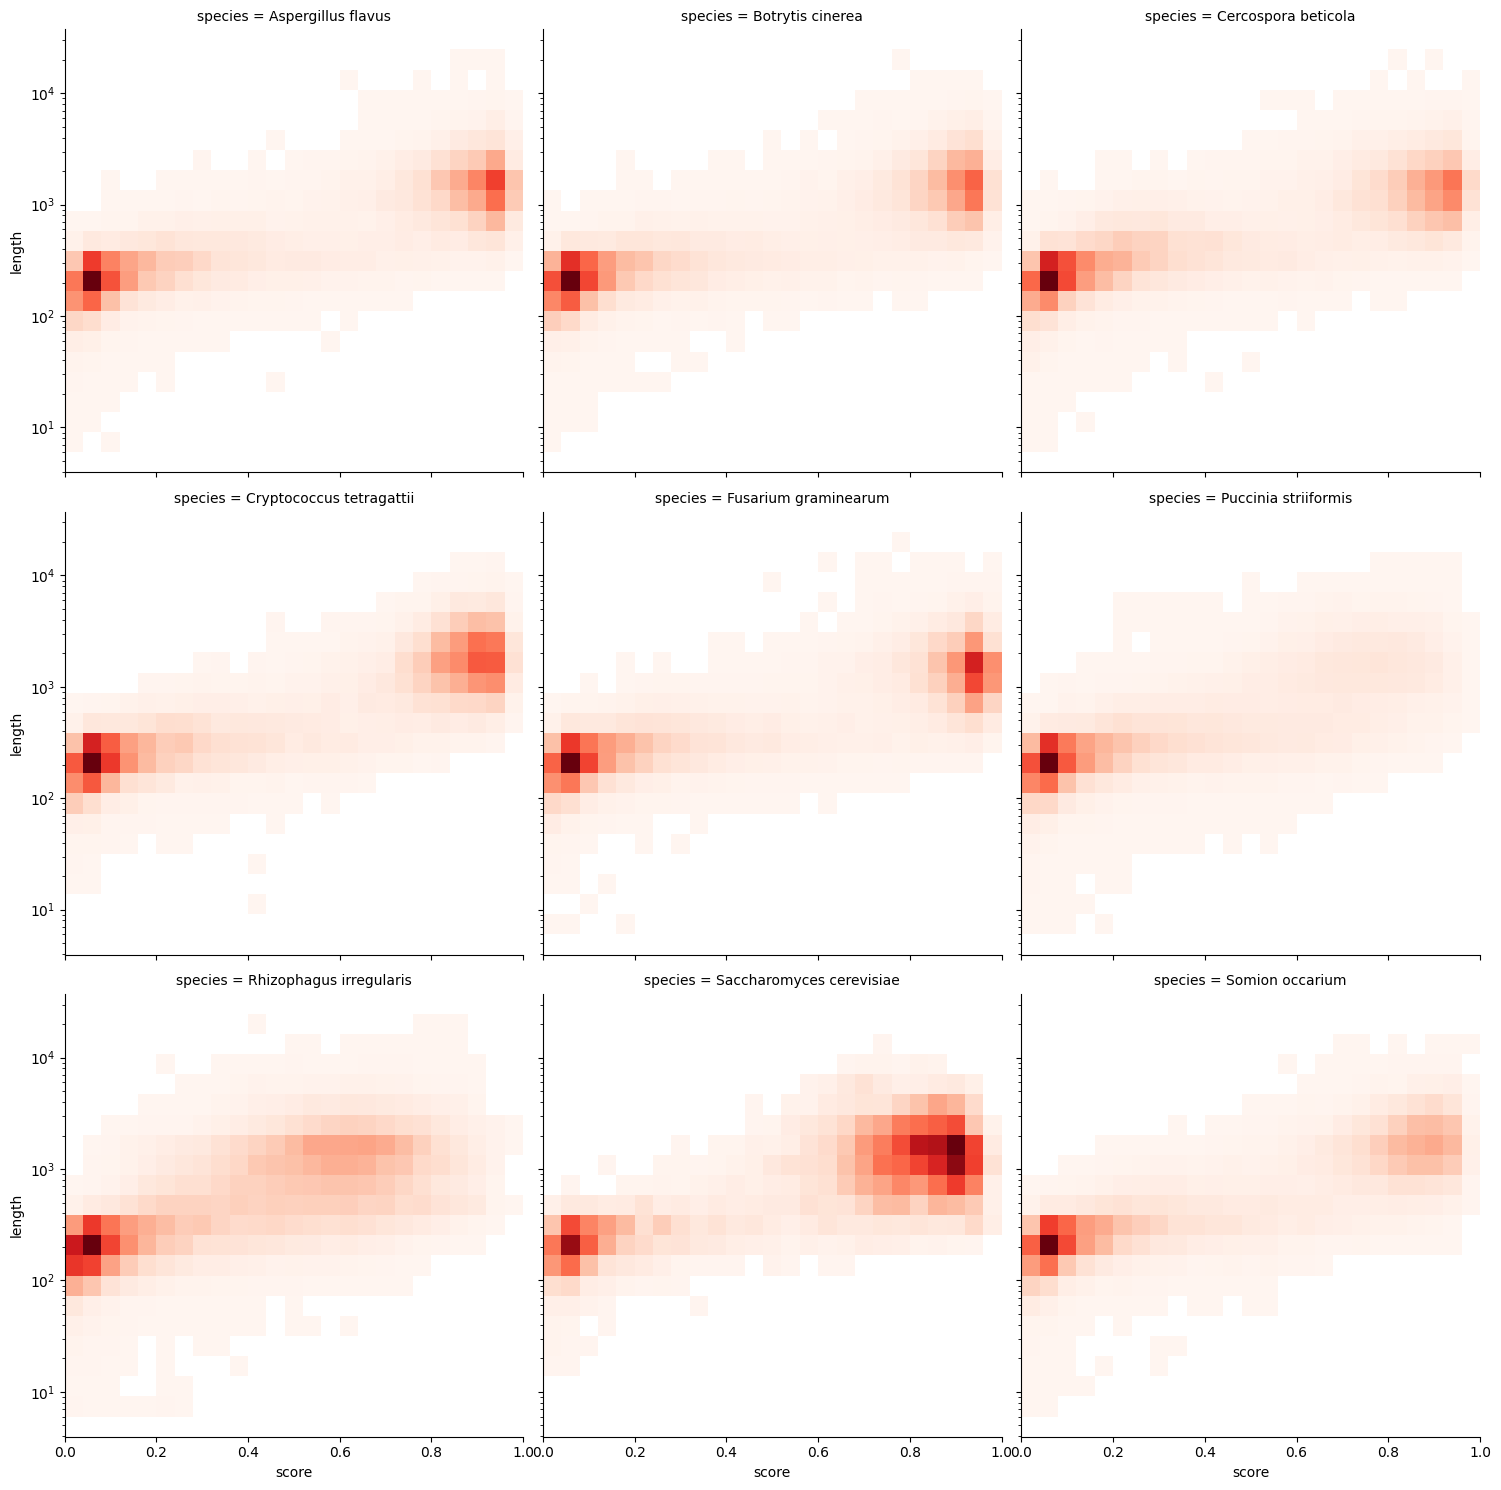

In [60]:
g = sns.displot(data=all_scores, y="length", x="score", col="species", col_wrap=3, cmap='Reds', log_scale=(False, True), bins=(25, 20), common_norm=False, binrange=((0, 1), None))
g.set(xlim=(0, 1))

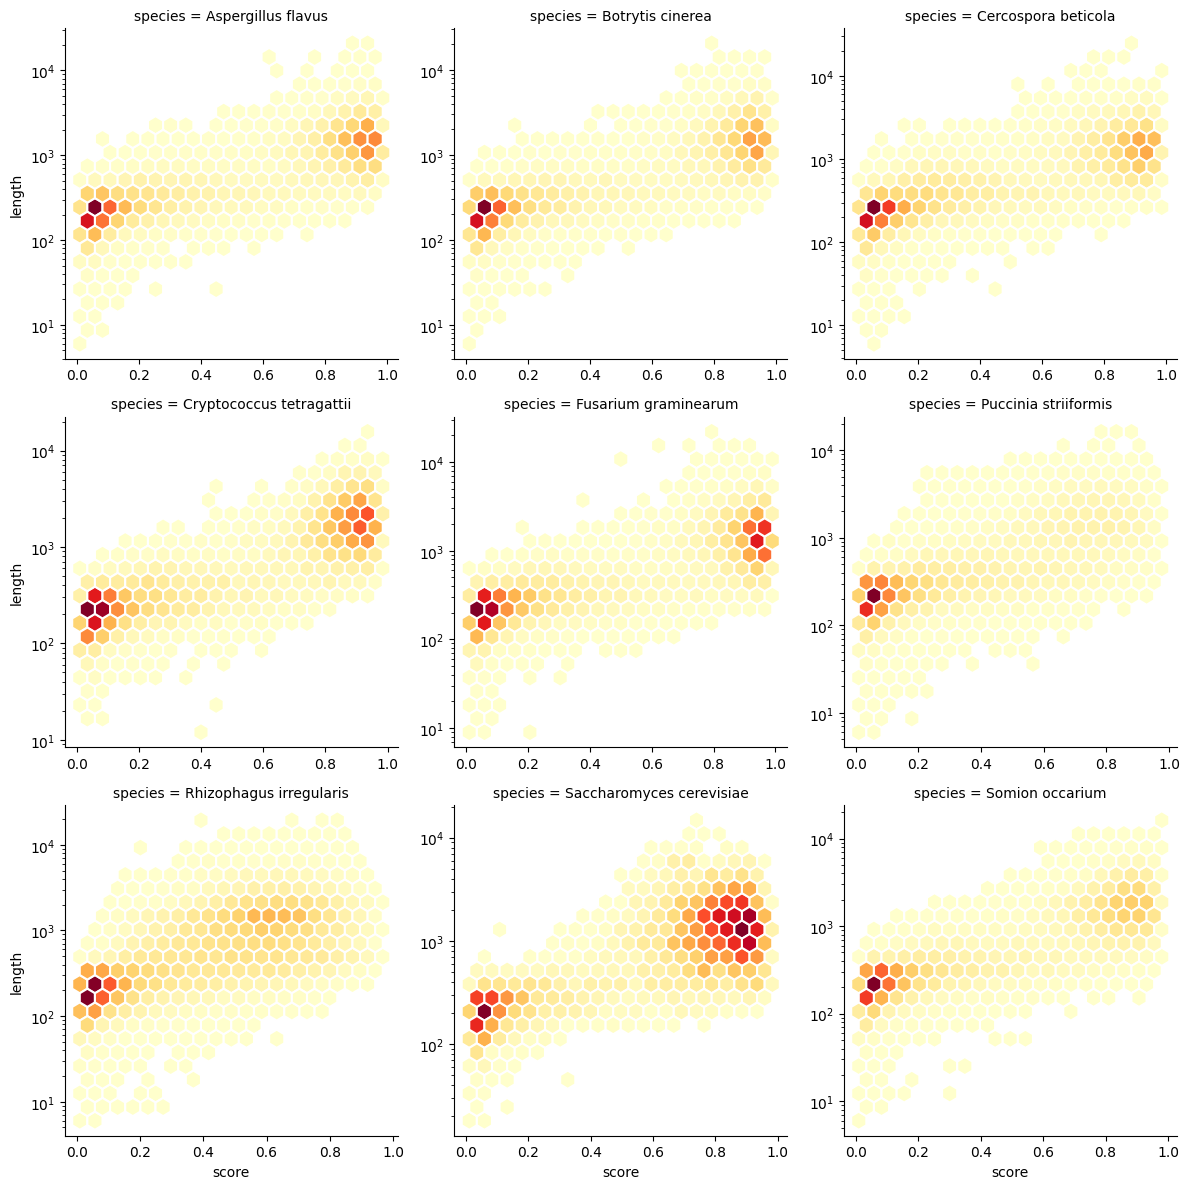

In [33]:
g = sns.FacetGrid(all_scores, col="species", col_wrap=3, height=4, aspect=1, sharex=False, sharey=False)
g.map(plt.hexbin, "score", "length", gridsize=20, yscale='log', cmap='YlOrRd', mincnt=1, linewidths=1.5, edgecolors='none', reduce_C_function=np.sum)
for ax in g.axes.flat:
    for collection in ax.collections:
        collection.set_edgecolor('white')
        collection.set_linewidth(1.5)
        # Normalize color scale per subplot
        collection.set_clim(vmin=collection.get_array().min(), vmax=collection.get_array().max())

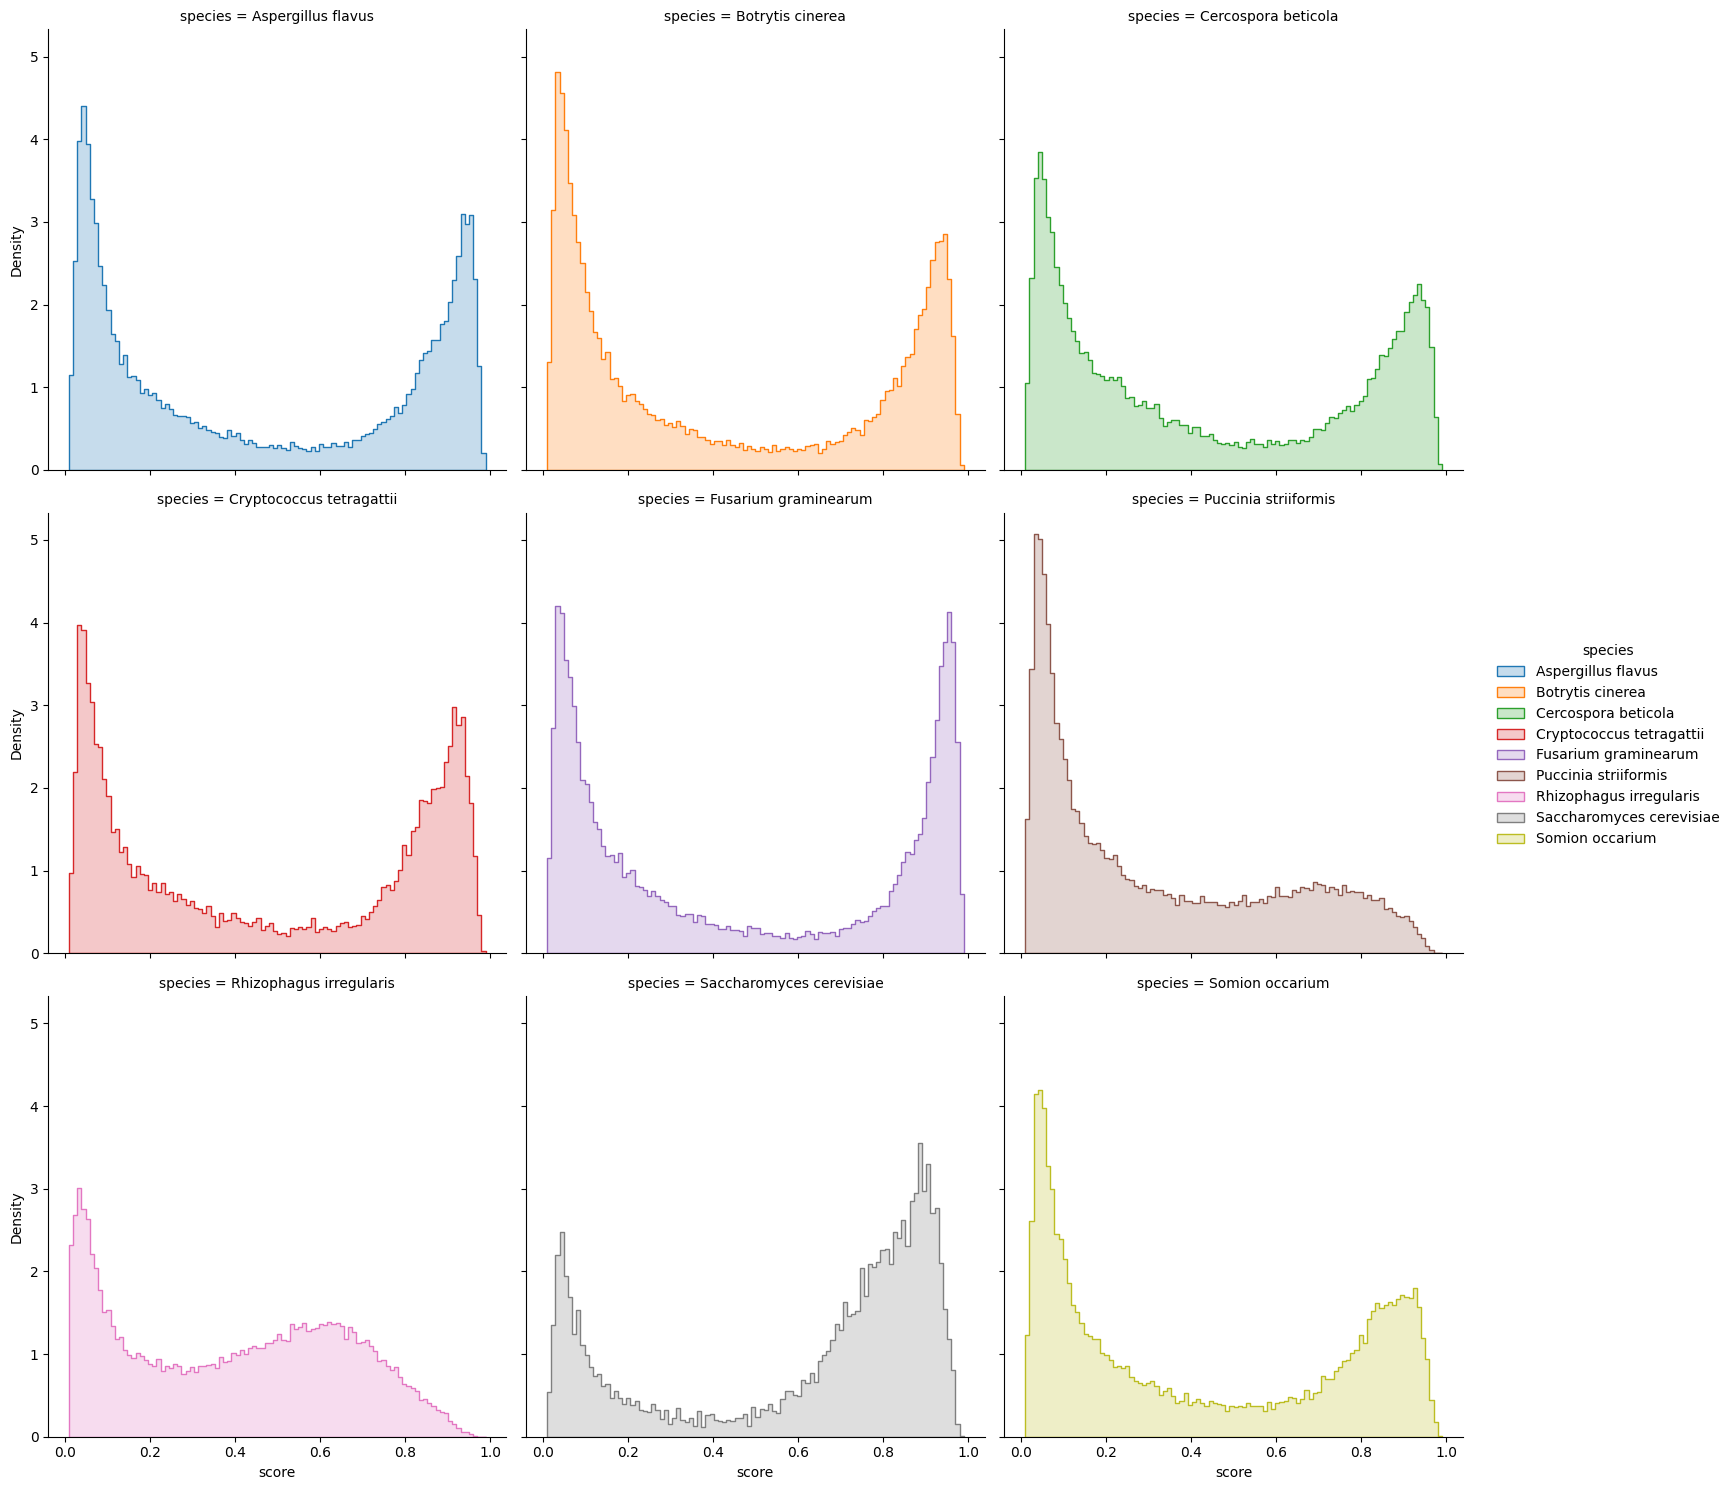

In [14]:
sns.displot(data=all_scores, x="score", hue="species", element="step",
            stat="density", common_norm=False, col="species", col_wrap=3, bins=100)

/tmp/ipykernel_1173/2034624887.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_thresholds = all_scores.groupby('species')['threshold'].first()


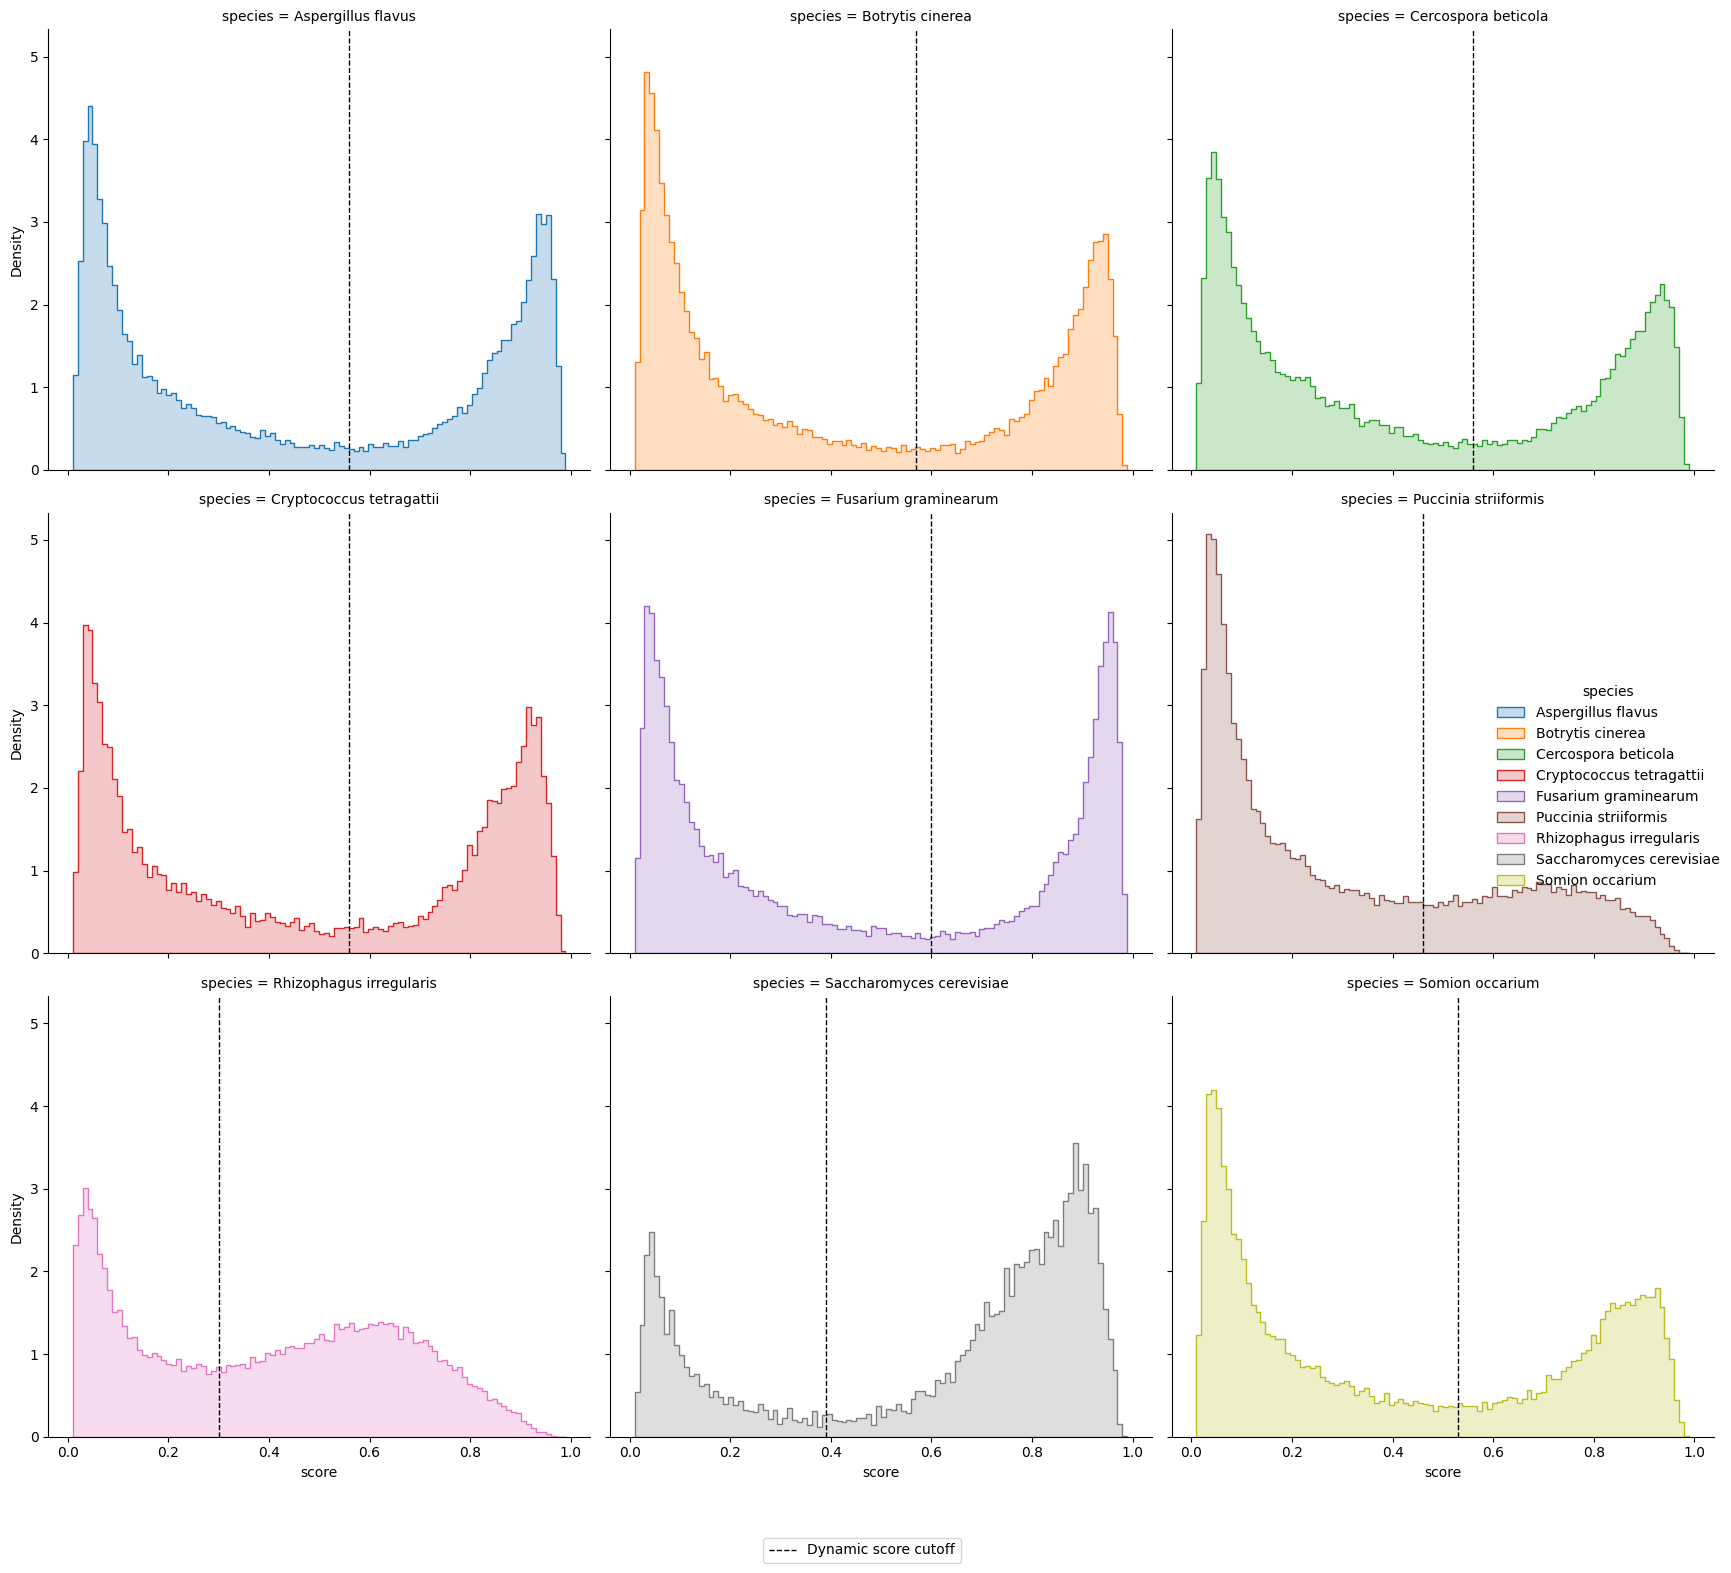

In [71]:
# Add vertical lines to each subplot using threshold from dataframe
g = sns.displot(data=all_scores, x="score", hue="species", element="step",
            stat="density", common_norm=False, col="species", col_wrap=3, bins=100)

# Get unique species and their thresholds
species_thresholds = all_scores.groupby('species')['threshold'].first()

for i, (ax, species) in enumerate(zip(g.axes.flat, species_thresholds.index)):
    threshold = species_thresholds[species]
    if i == 0:
        ax.axvline(x=threshold, color='black', linestyle='--', linewidth=1, label='Dynamic score cutoff')
    else:
        ax.axvline(x=threshold, color='black', linestyle='--', linewidth=1)

# Add legend below all plots
g.fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=1)
g.fig.tight_layout()

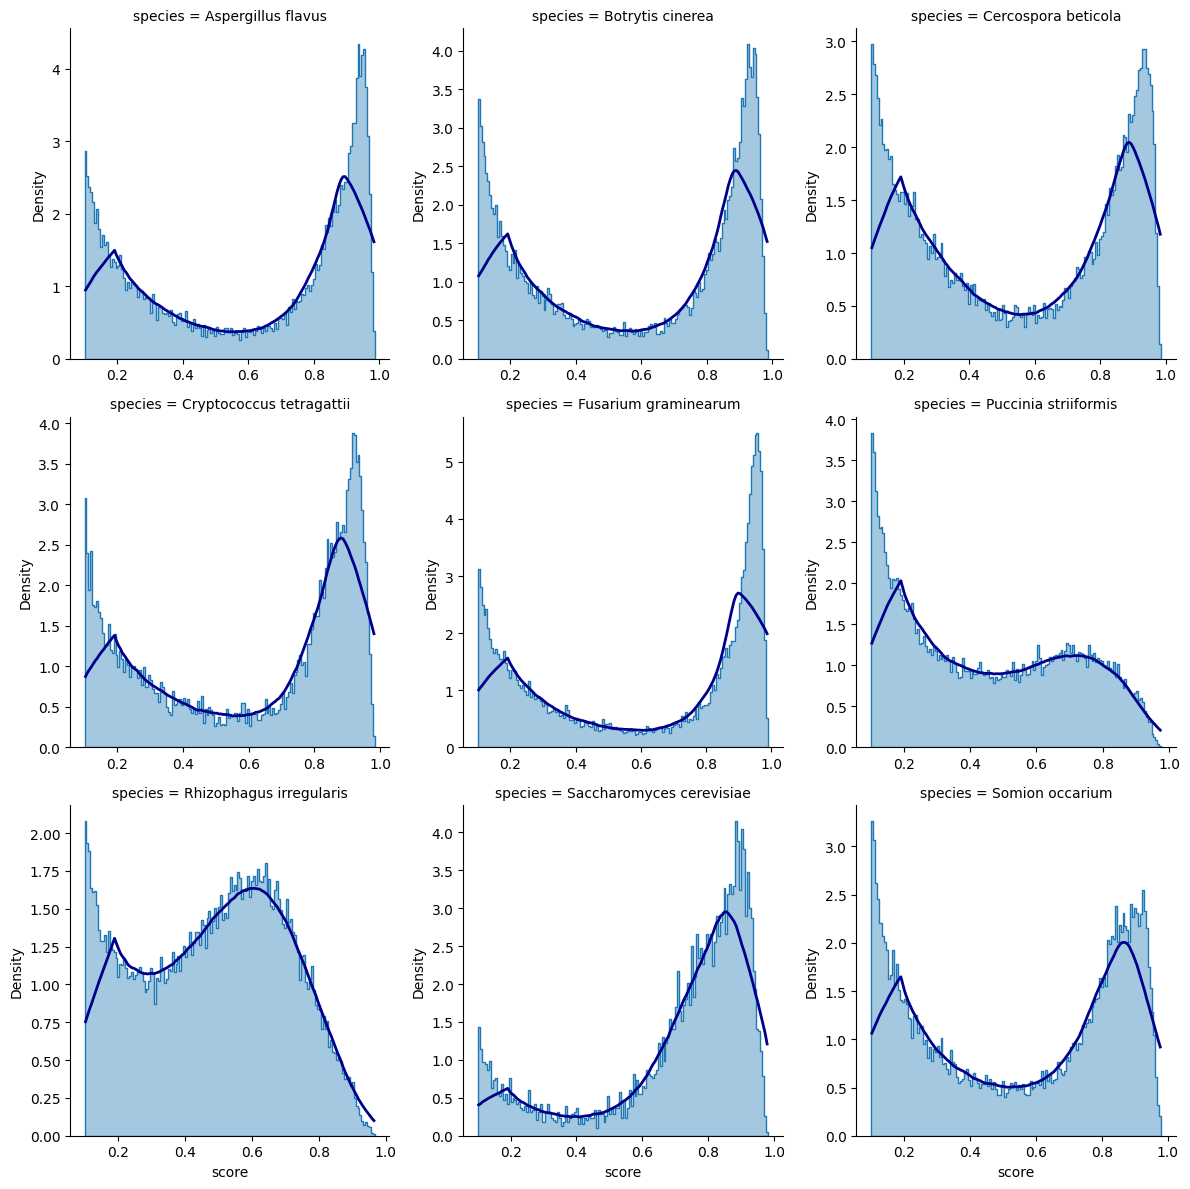

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_with_smoothing(x, **kwargs):
    # Calculate histogram
    counts, bin_edges = np.histogram(x, bins=150, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Apply smoothing
    window_size = 30
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(counts, window, mode='same')

    # Plot smoothed line
    plt.plot(bin_centers, smoothed, color='darkblue', linewidth=2)

# Create FacetGrid to replicate the layout with the smoothed line overlay
g = sns.FacetGrid(all_scores, col="species", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "score", stat="density", bins=150, element="step", alpha=0.4)
g.map(plot_with_smoothing, "score")